<a href="https://colab.research.google.com/github/Epicencas/Lab3SL2/blob/rama1/Lab3SL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preparación del Ambiente

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

### Carga de la Data

In [2]:
data_path1 = '/content/drive/MyDrive/trainRNN.csv'
dataset = pd.read_csv(data_path1 , parse_dates=['date'])

### Autocorrelación de los Datos


La autocorrelación es considerablemente alta, por lo que un determinado valor depende de datos anteriores y por lo tanto se puede hacer una predicción.

In [3]:
#autocorrelación
dataset['sales'].autocorr(lag=1)

0.8784369673919291

### Gráfica AutoCorrelation Function

In [4]:
#fig = plot_acf(dataset['sales'], lags=20, alpha=0.05)
#fig.show()

### Gráfico de Descomposición

In [5]:
#seleccionar solo la columan date y high
datos_sales = dataset[['date','sales']]
#fijar la fecha como indice del data.frame
datos_ts =  datos_sales.set_index('date')
#organizar a partir del indice
datos_ts.sort_index(inplace=True)
#ver el conjunto de datos
#datos_ts.head()

#### Gráfica completa de las ventas

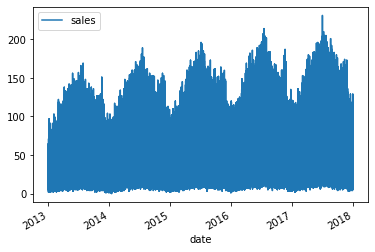

In [6]:
datos_ts.plot()

#### Se utilizará método aditivo ya que al contener un 0 el modelo multiplicativo da error.

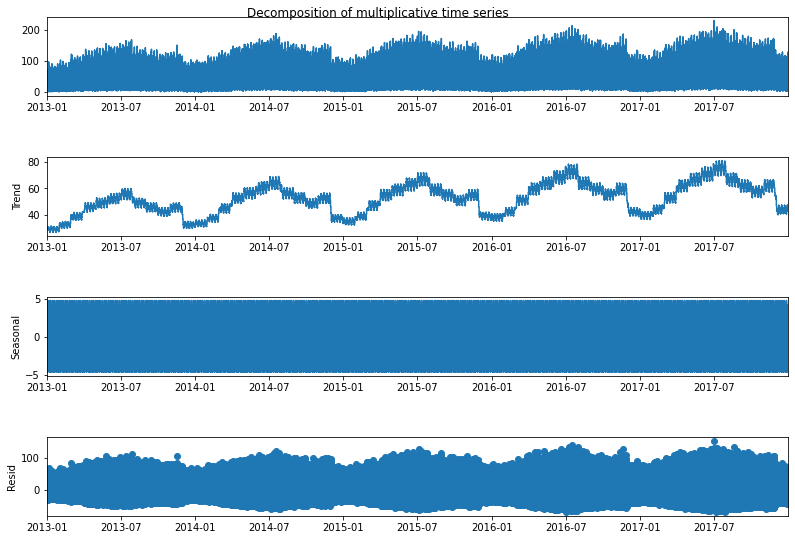

In [7]:
decomposition = sm.tsa.seasonal_decompose(datos_ts, model='additive', period = int(len(datos_ts)/400))

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
fig.show()

#### Para visualizar mejor los resultados se hace un promedio por mes

In [8]:
datos_ts_m = datos_ts.resample('M').mean()
datos_ts_m.head()

,sales
date,
2013-01-31,29.348645
2013-02-28,32.815500
2013-03-31,39.831097
2013-04-30,45.484933
2013-05-31,49.241419


#### Con el promedio se puede usar el modelo multiplicativo pues ya no hay valores 0 ni negativos. Se observa el comportamiento ciclico de la data así como la temporalidad que tiene a mediados de año.

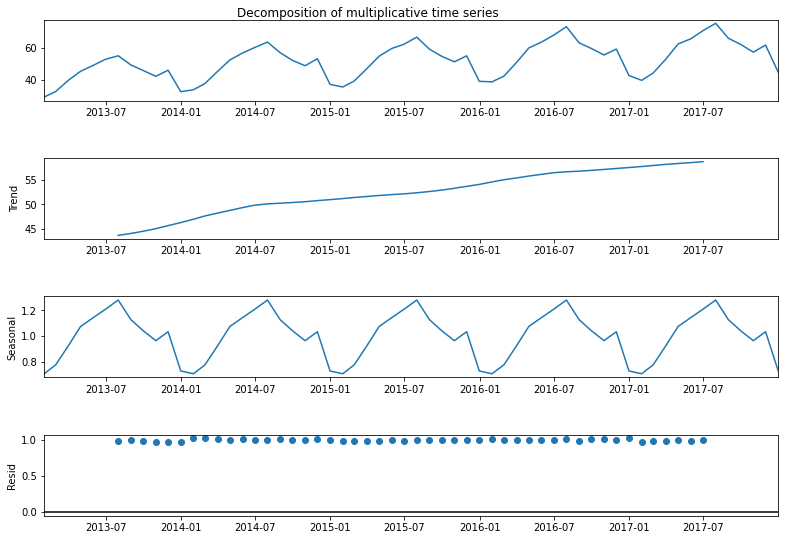

In [9]:
decomposition = sm.tsa.seasonal_decompose(datos_ts_m, model='multiplicative')

fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
fig.show()

### Data de Entrenamiento (80% del total de la data)

In [10]:
data_path1 = '/content/drive/MyDrive/trainRNN.csv'
dataset = pd.read_csv(data_path1 )

In [11]:
datatrain = dataset[dataset['date'].str.contains('2013|2014|2015|2016', regex=True)]
datatrain

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912630,2016-12-27,10,50,60
912631,2016-12-28,10,50,43
912632,2016-12-29,10,50,68
912633,2016-12-30,10,50,63


### Data de Validación (20% del total de la data)

In [12]:
datatest = dataset[dataset['date'].str.contains('2017')]
datatest

,date,store,item,sales
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


#### Procesamiento de la data: Se hace un pivote de los 50 items de cada una de las 10 tiendas.

#### Tienda 1

In [13]:
datatrain1 = datatrain.query('store == 1')
datatrain1 = datatrain1.pivot(index = 'date', columns = 'item', values = 'sales')
datatrain1['Total_Sales'] = datatrain1.sum(axis = 1)
datatrain1 = datatrain1.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatrain1 = datatrain1.iloc[:, 0:1].values

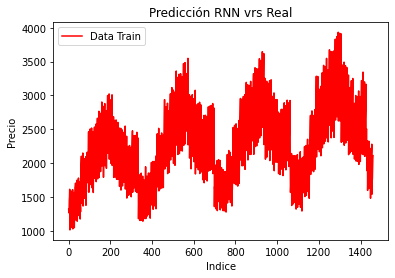

In [14]:
plt.plot(datatrain1, color='red', label='Data Train')
plt.title('Predicción RNN vrs Real')
plt.xlabel("Indice")
plt.ylabel("Precio")
plt.legend()
plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
datatrain1_scaled = scaler.fit_transform(datatrain1)

In [16]:
X_train = []
Y_train = []

#secuenciamos los datos.
cantidad = datatrain1_scaled.shape[0]
ventana = 60
for i in range(ventana, cantidad):
  X_train.append(datatrain1_scaled[i - ventana: i, 0])
  Y_train.append(datatrain1_scaled[i, 0])

In [17]:
X_train = np.array(X_train)
y_train = np.array(Y_train)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #reshape para entrada en Keras.

In [19]:
forecaster = Sequential()
#capa1
forecaster.add(LSTM(input_shape=(X_train.shape[1], 1), units=50, return_sequences=True))
#capa2
forecaster.add(LSTM(units=50, return_sequences=True))
#capa3
forecaster.add(LSTM(units=25, return_sequences=True))
#capa4 - NOTAAAAR :) que la capa previa a la salida, no requiere feedback ya que es el resultado final.
forecaster.add(LSTM(units=75, return_sequences=False))
#capa de salida
forecaster.add(Dense(units=1, activation='relu'))

In [20]:
#parametros de optimización
forecaster.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
#parametros de entrenamiento
forecaster.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
44/44 [==============================] - 12s 116ms/step - loss: 0.0357
Epoch 2/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0157
Epoch 3/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0153
Epoch 4/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0149
Epoch 5/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0139
Epoch 6/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0140
Epoch 7/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0138
Epoch 8/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0135
Epoch 9/100
44/44 [==============================] - 5s 117ms/step - loss: 0.0135
Epoch 10/100
44/44 [==============================] - 5s 118ms/step - loss: 0.0137
Epoch 11/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0135
Epoch 12/100
44/44 [==============================] - 5s 115ms/step - loss: 0.0134
Epoch 13/100

In [22]:
#forecaster.save('/content/drive/MyDrive/RNN_v1.h5')

In [23]:
datatest1 = datatest.query('store == 1')
datatest1 = datatest1.pivot(index = 'date', columns = 'item', values = 'sales')
datatest1['Total_Sales'] = datatest1.sum(axis = 1)
datatest1 = datatest1.drop([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], axis=1)
datatest1 = datatest1.iloc[:, 0:1].values

In [24]:
real_test_price = datatest1

In [25]:
dataset_total = pd.concat((pd.Series(datatrain1[:,0]), pd.Series(datatest1[:,0])), axis=0)
#dataset_total

0      1316
1      1264
2      1305
3      1452
4      1499
       ... 
360    1837
361    1951
362    2116
363    2304
364    2388
Length: 1826, dtype: int64

In [26]:
input_test = dataset_total[len(dataset_total) - len(datatest1) - ventana : ].values
input_test = input_test.reshape(-1, 1)
input_test = scaler.transform(input_test)
#input_test

array([[0.53422313],
       [0.53524983],
       [0.61670089],
       [0.6724846 ],
       [0.75564682],
       [0.38466804],
       [0.49212868],
       [0.52703628],
       [0.55475702],
       [0.64339493],
       [0.7128679 ],
       [0.79842574],
       [0.38090349],
       [0.52087611],
       [0.50616016],
       [0.59548255],
       [0.61806982],
       [0.69062286],
       [0.74880219],
       [0.37234771],
       [0.48939083],
       [0.53285421],
       [0.57221081],
       [0.62799452],
       [0.65811088],
       [0.73716632],
       [0.3744011 ],
       [0.50616016],
       [0.5109514 ],
       [0.30047912],
       [0.33572895],
       [0.37679671],
       [0.45106092],
       [0.19986311],
       [0.25564682],
       [0.2522245 ],
       [0.28097194],
       [0.36310746],
       [0.40451745],
       [0.44900753],
       [0.21115674],
       [0.24332649],
       [0.270705  ],
       [0.29637235],
       [0.38637919],
       [0.40520192],
       [0.41204654],
       [0.160

In [27]:
cantidad_final = len(input_test)
cantidad_final

425

In [28]:
X_test = []
for i in range(ventana, cantidad_final):
  X_test.append(input_test[i - ventana:i, 0])

X_test = np.array(X_test)

In [29]:
X_test.shape

(365, 60)

In [30]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [31]:
X_test.shape

(365, 60, 1)

In [32]:
predicciones_rnn = forecaster.predict(X_test)
#predicciones_rnn

array([[0.40127125],
       [0.14024882],
       [0.22055313],
       [0.21137965],
       [0.2445068 ],
       [0.29133415],
       [0.33672813],
       [0.36659864],
       [0.12875658],
       [0.21762496],
       [0.22485483],
       [0.2682142 ],
       [0.33165145],
       [0.34863248],
       [0.37244913],
       [0.11829261],
       [0.21977186],
       [0.22382617],
       [0.26754686],
       [0.3265793 ],
       [0.35551497],
       [0.38878703],
       [0.11978461],
       [0.21456352],
       [0.21592996],
       [0.2596922 ],
       [0.33088502],
       [0.3430919 ],
       [0.37668133],
       [0.11578447],
       [0.20531738],
       [0.21087724],
       [0.2639751 ],
       [0.32968265],
       [0.41281322],
       [0.4465481 ],
       [0.18295026],
       [0.27197915],
       [0.27710566],
       [0.3144196 ],
       [0.3569192 ],
       [0.40049043],
       [0.42908522],
       [0.16135243],
       [0.2668929 ],
       [0.27229115],
       [0.32117116],
       [0.371

In [33]:
real_predicted_price = scaler.inverse_transform(predicciones_rnn)
#real_predicted_price

array([[2184.5146],
       [1421.8071],
       [1656.4563],
       [1629.6514],
       [1726.4489],
       [1863.2784],
       [1995.9196],
       [2083.2012],
       [1388.2267],
       [1647.9003],
       [1669.0259],
       [1795.7219],
       [1981.0856],
       [2030.7041],
       [2100.2964],
       [1357.651 ],
       [1654.1735],
       [1666.0201],
       [1793.772 ],
       [1966.2648],
       [2050.8147],
       [2148.036 ],
       [1362.0106],
       [1638.9546],
       [1642.9473],
       [1770.8207],
       [1978.8461],
       [2014.5146],
       [2112.6628],
       [1350.3223],
       [1611.9375],
       [1628.1833],
       [1783.3353],
       [1975.3328],
       [2218.2402],
       [2316.8137],
       [1546.5807],
       [1806.7231],
       [1821.7028],
       [1930.734 ],
       [2054.918 ],
       [2182.2332],
       [2265.787 ],
       [1483.4718],
       [1791.8612],
       [1807.6348],
       [1950.4623],
       [2098.8337],
       [2265.497 ],
       [2342.0728],


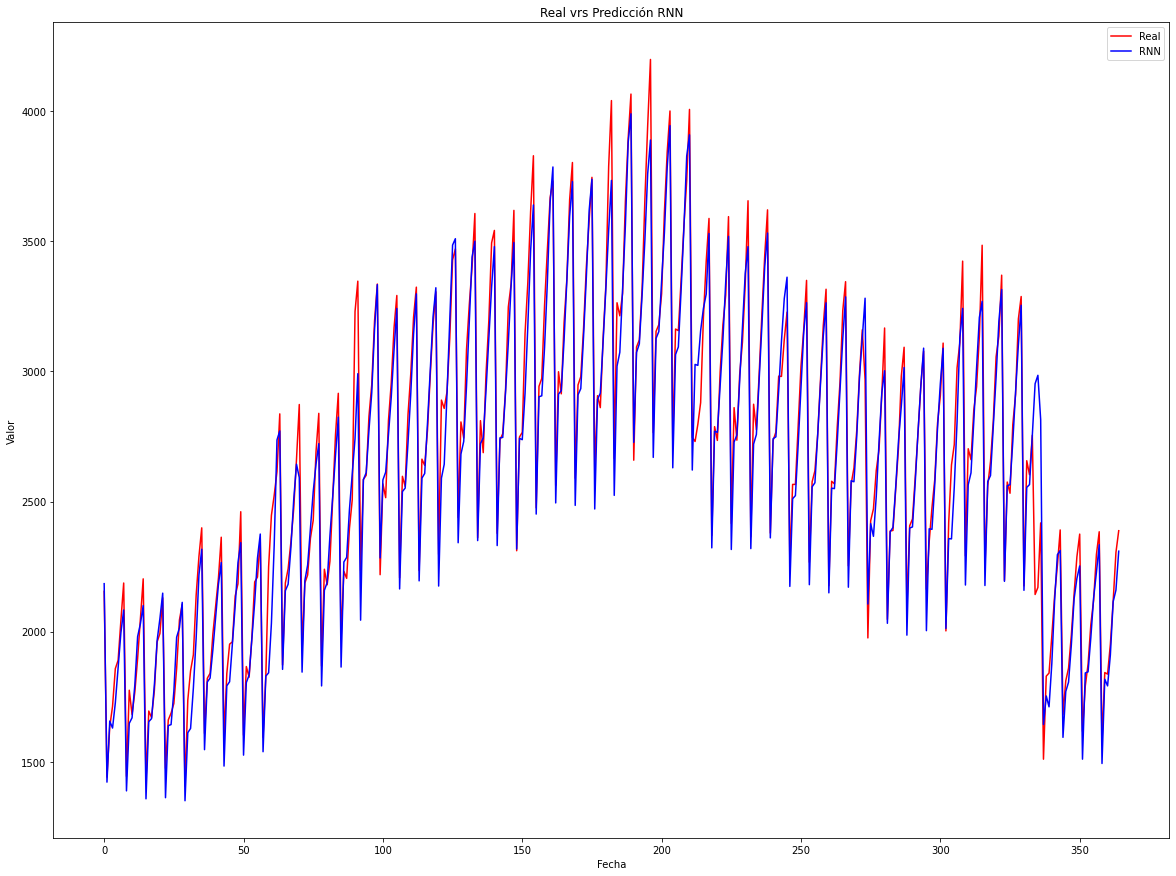

In [38]:
plt.figure(figsize=(20, 15))
plt.plot(real_test_price, color="red", label="Real")
plt.plot(real_predicted_price, color="blue", label="RNN")
plt.title("Real vrs Predicción RNN")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.show()

### Calculo SMAPE Tienda 1

In [46]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

In [47]:
smape(real_test_price, real_predicted_price)

3.0214729115924017